# DoA Estimation for Wideband Chirps in FrFT Domain #
<p>v1.0 2025</p>

__By__ Eulogio Gutierrez Huampo

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as ss
from numpy import pi,cos,sin,sqrt

import sys
sys.path.append('./src')
import doa_utils as DoA

In [2]:
import ipywidgets as widgets
from IPython.display import display

# Dropdown menu to select mode
mode_selector = widgets.Dropdown(
    options=['dfrft', 'dsmfrft'],
    value='dsmfrft',
    description='Operator:',
)

### Signal Modeling

__Time axis__

In [3]:
L_sig = 5e-6 # Duration of signal
N = 1024 # Number of snapshots
fs = N/L_sig # sampling rate
no = N//2 # index of tt=0
tt = np.arange(-no,-no+N)/float(fs) # time axis

__Multi-component linear frequency-modulated (LFM) signal__

In [4]:
fc_list = 1e6 * np.array([10, 15, 20]) # center frequencies
B = 20e6 # bandwidth
mu_list = np.tile(B/L_sig, len(fc_list)) # chirp rates

__Uniform linear array (ULA)__ 

In [5]:
c = 3e8 # light speed, m/s
f2 = np.max(fc_list)+B/2 # highest frequency
lam = c/f2 # wavelength
d = lam/2 # adjacency distance
M = 41 # Number of array elements
mo = M//2 # index of ula=0
ula = d*np.arange(-mo,-mo+M) # ULA

__Received signals__

In [6]:
doa_list = [-40, 20, 40]  # True DOAs, degrees
snr = -10 # signal to noise ratio
received_signals = DoA.output_signal_ULA(tt,fc_list,mu_list,ula,
                                         np.radians(doa_list),snr,c)

### Preprocessing

In [7]:
# Display the dropdown and button
display(mode_selector)

Dropdown(description='Operator:', index=1, options=('dfrft', 'dsmfrft'), value='dsmfrft')

__Optmal fractional order__

In [8]:
cot_alpha = B/L_sig * N/fs**2 # cot(aOP*pi/2) 
if cot_alpha==0: # Avoid division by zero
    aOP = 1.0
else:    
    aOP = (2/pi)*(pi-np.arctan(1/cot_alpha))    
print(f"Optmal fractional order: {aOP}")

Optmal fractional order: 1.0619733900739727


__Peak indices at reference sensor__

In [9]:
op = mode_selector.value
if op=='dfrft':
    qOP = np.round(fc_list*L_sig*np.sin(aOP*pi/2))   
elif op=='dsmfrft':
    qOP = np.round(fc_list*L_sig)
else:
    raise Warning("Invalid operator!") 
print('Peak indices: ',qOP+N//2)      

Peak indices:  [562. 587. 612.]


### Multi-target direction-of-arrival (DoA) estimation

__Piecewise linear regression__

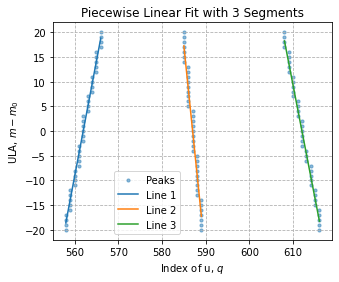

In [10]:
# Example Usage
K = 3  # Number of lines to fit
y,x = DoA.multi_peaks_ULA(received_signals,tt,ula,aOP,qOP,op,c)
models, segments = DoA.fit_k_lines(x, y, K)
DoA.plot_results_line_fitting(x, y, models, segments)

In [11]:
doa_plf_list = []
for i in range(K):
    slope, intercept = models[i]
    doa = DoA.doa_line_fitting(fs,d,1.0/slope,aOP,op,c)
    doa_plf_list.append(doa*180/pi)
doa_plf = np.sort(doa_plf_list)    
# Display Results
print(f"True DOAs: {doa_list}")
print(f"Estimated DOAs (Line Fitting): {np.round(doa_plf,2)}")    

True DOAs: [-40, 20, 40]
Estimated DOAs (Line Fitting): [-39.91  20.36  41.11]


__Line detection in Hough space__

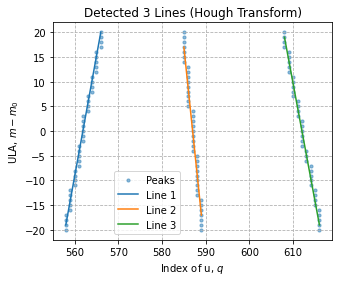

In [12]:
K = 3  # Number of lines to detect
y,x = DoA.multi_peaks_ULA(received_signals,tt,ula,aOP,qOP,op,c)
models, lines = DoA.hough_line_fitting(x, y, K)
DoA.plot_results_detected_lines(x, y, models, lines)

In [13]:
doa_ht_list = []
for slope, intercept in models:
    doa = DoA.doa_line_fitting(fs,d,-1.0/slope,aOP,op,c)
    doa_ht_list.append(doa*180/pi)   
doa_ht = np.sort(doa_ht_list)    
# Display Results
print(f"True DOAs: {doa_list}")
print(f"Estimated DOAs (HT Line Fitting): {np.round(doa_ht,2)}")

True DOAs: [-40, 20, 40]
Estimated DOAs (HT Line Fitting): [-37.98  20.67  39.17]


__MUSIC with spatial smoothing and forward-backward averaging__

In [14]:
Lsub = M//2 # size of subarrays
align = True # peak alignment

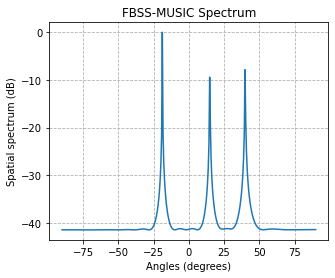

In [15]:
# Estimating DOA using MUSIC and FrFT
i = 2
angles, music_spectrum = DoA.music_frft(tt,received_signals,mo,qOP,d,aOP,Lsub,i,op,align,c)
music_spectrum_dB = 10 * np.log10(music_spectrum / np.max(music_spectrum))
# Plot MUSIC Spectrum
plt.figure(figsize=(5, 4))
plt.plot(angles, music_spectrum_dB)
plt.title('FBSS-MUSIC Spectrum')
plt.xlabel('Angles (degrees)')
plt.ylabel('Spatial spectrum (dB)')
plt.grid(linestyle= "--") 
plt.show()

In [16]:
# Inices of DOA using MUSIC and FrFT
idxMUSIC,_= ss.find_peaks(music_spectrum_dB ,height=-10.0, distance=1.5)
doa_music = angles[idxMUSIC]
# Display Results
print(f"True DOAs: {doa_list}")
print(f"Estimated DOAs (FBSS-MUSIC): {np.round(doa_music,2)}")

True DOAs: [-40, 20, 40]
Estimated DOAs (FBSS-MUSIC): [-18.8   14.79  39.86]


Null-cross interference!

__ESPRIT with spatial smoothing and forward-backward averag__

In [17]:
# Estimate DOA using ESPRIT with FrFT
estimated_doas = DoA.esprit_frft(tt,received_signals,mo,qOP,d,aOP,Lsub,op,align,c)
doa_esprit = np.sort(np.degrees(estimated_doas))
# Display Results
print(f"True DOAs: {doa_list}")
print(f"Estimated DOAs (FBSS-ESPRIT): {np.round(doa_esprit,2)}")

True DOAs: [-40, 20, 40]
Estimated DOAs (FBSS-ESPRIT): [-40.11  20.02  39.99]
